# Advanced: Resampling Emcee from a Previous Run

**IMPORTANT**: this tutorial assumes basic knowledge (and uses a file resulting from) the [emcee tutorial](./emcee.ipynb).

## Setup

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

We'll then start with the bundle from the end of the [emcee tutorial](./emcee.ipynb).  If you're running this notebook locally, you will need to run that first to create the `emcee_advanced_tutorials.bundle` file that we will use here.

In [3]:
b = phoebe.load('emcee_advanced_tutorials.bundle')

## init_from parameter

In cases where [continuing emcee from a previous run](./emcee_continue_from.ipynb) is insufficient, it may be ncessary to resample a new emcee run from the results of a previous run.  This can be useful in several scenarios:

* change the number of walkers
* resample from the "best" branch when other branches are stuck (NOTE: this is making some assumptions and should be used with caution)
* change the parameters being sampled (in this case, any NEW parameter will need to have initializing distributions created manually or from some other source)
* "merge" the results from multiple emcee runs  (if RV- and LC-sensitive parameters were sampled independently but now you want to resample simultaneously)

In all of these cases, we simply need to set the `init_from` parameter to a distribution that was created from the results of a previous emcee solution.

In [4]:
print(b.get_parameter(qualifier='init_from', solver='emcee_solver'))

Parameter: init_from@emcee_solver@solver
                       Qualifier: init_from
                     Description: distribution(s) to initialize samples from (all unconstrained parameters with attached distributions will be sampled/fitted, constrained parameters will be ignored, covariances will be respected)
                           Value: ['ball_around_guess']
                         Choices: ball_around_guess, emcee_posteriors
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: continue_from:None



Here we can see that we now have the additional choice of 'emcee_posteriors' (created in the [emcee_tutorial](./emcee.ipynb) by calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution) on the emcee solution.

If we wanted to start from these posteriors as they are, we would just set `init_from` to 'emcee_posteriors' and then call `run_solver` (this would be sufficient for changing the number of walkers without needing to completely start from scratch).

But let's discuss some of the considerations for the other use-cases mentioned above.  In order to re-sample from a branch in the previous run, we would need to call `adopt_solution` with the appropriate value of `lnprob_cutoff` to isolate that top branch.  In this case we don't have branches, but can still illustrate the concept:

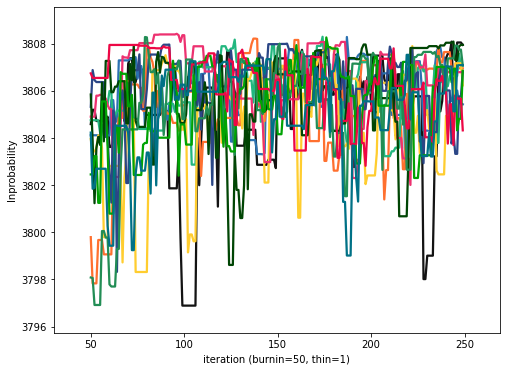

In [5]:
_ = b.plot(solution='emcee_sol', style='lnprobability', show=True)

In [6]:
b.set_value('lnprob_cutoff', solution='emcee_sol', value=3796)

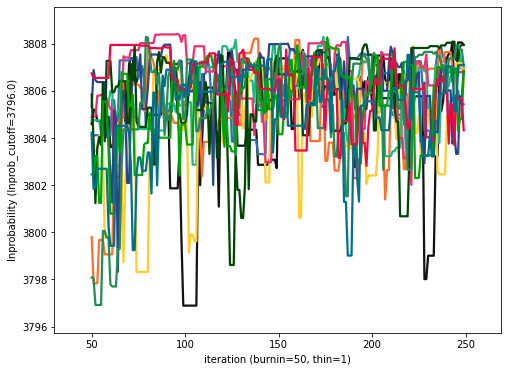

In [7]:
_ = b.plot(solution='emcee_sol', style='lnprobability', show=True)

In [8]:
b.adopt_solution('emcee_sol', adopt_values=False, adopt_distributions=True, distribution='resample_branch')

<ParameterSet: 6 parameters | components: binary, primary>

In [9]:
b.set_value('init_from', solver='emcee_solver', value='resample_branch')

At this point we would call `b.run_solver(solver='emcee_solver', solution='resample_solution')` to start a new emcee run initialize from the distribution created from this top-branch from the previous run.

Now let's imagine that we also want to include an additional parameter in our next emcee run.  So far our initializing distribution contains the following:

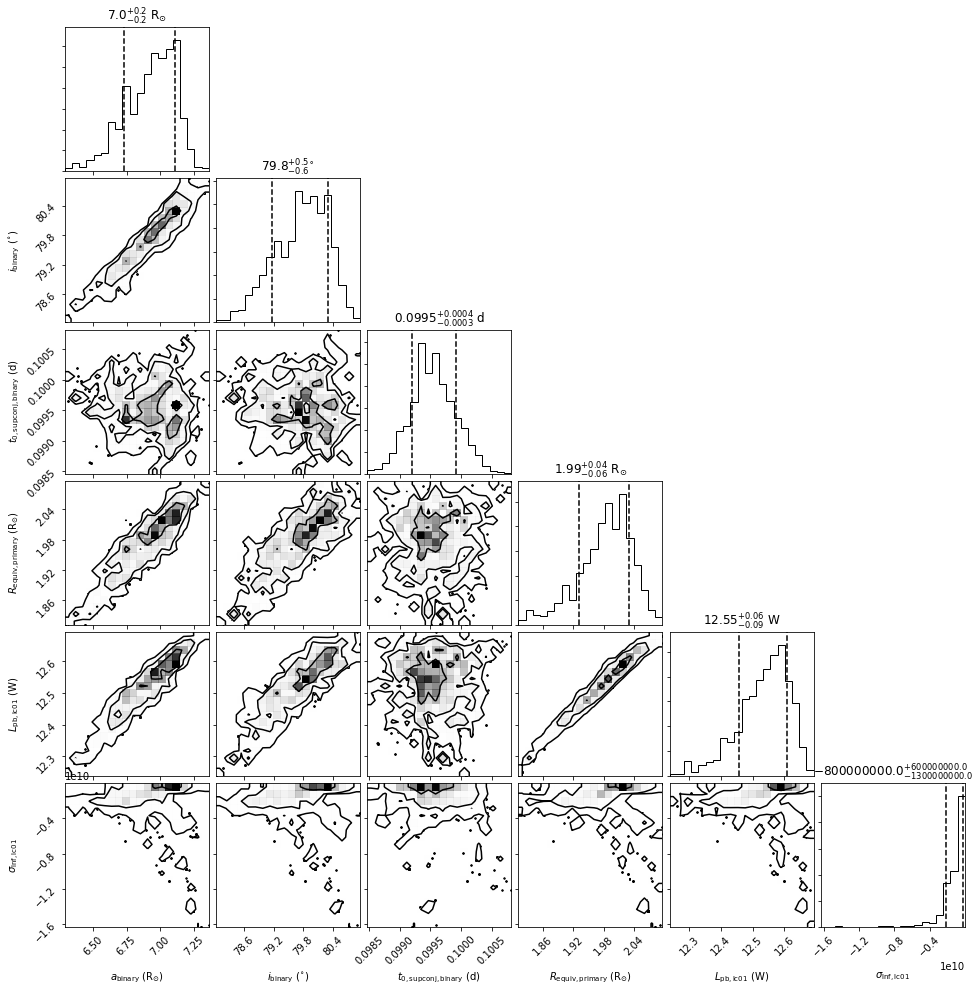

In [10]:
_ = b.plot_distribution_collection('resample_branch', show=True)

If we wanted to add additional parameters, we need to define their initial distributions via [b.add_distribution](../api/phoebe.frontend.bundle.Bundle.add_distribution.md).

By passing `distribution='resample_branch'`, they would be appended to the existing distribution collection, but we could also name then separately and combine them later.  For example:

In [11]:
b.add_distribution('requiv@secondary', phoebe.gaussian_around(200), distribution='init_from_new')

<ParameterSet: 1 parameters>

Now we need to set `init_from` to **both** of these distributions.

In [12]:
b.set_value('init_from', solver='emcee_solver', value=['resample_branch', 'init_from_new'])

Whenever `init_from` contains more than one distribution, they will be combined according to `init_from_combine` (and similarly for `priors` and `priors_combine`).

In [13]:
print(b.get_parameter('init_from_combine', solver='emcee_solver'))

Parameter: init_from_combine@emcee_solver@solver
                       Qualifier: init_from_combine
                     Description: Method to use to combine multiple distributions from init_from for the same parameter.  first: ignore duplicate entries and take the first in the init_from parameter. and: combine duplicate entries via AND logic, dropping covariances.  or: combine duplicate entries via OR logic, dropping covariances.
                           Value: first
                         Choices: first, and, or
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: continue_from:None,init_from:<notempty>



In this case, 'first' is sufficient as we don't have multiple distributions describing the same parameter.  Now we can plot the *combined* initializing distribution.

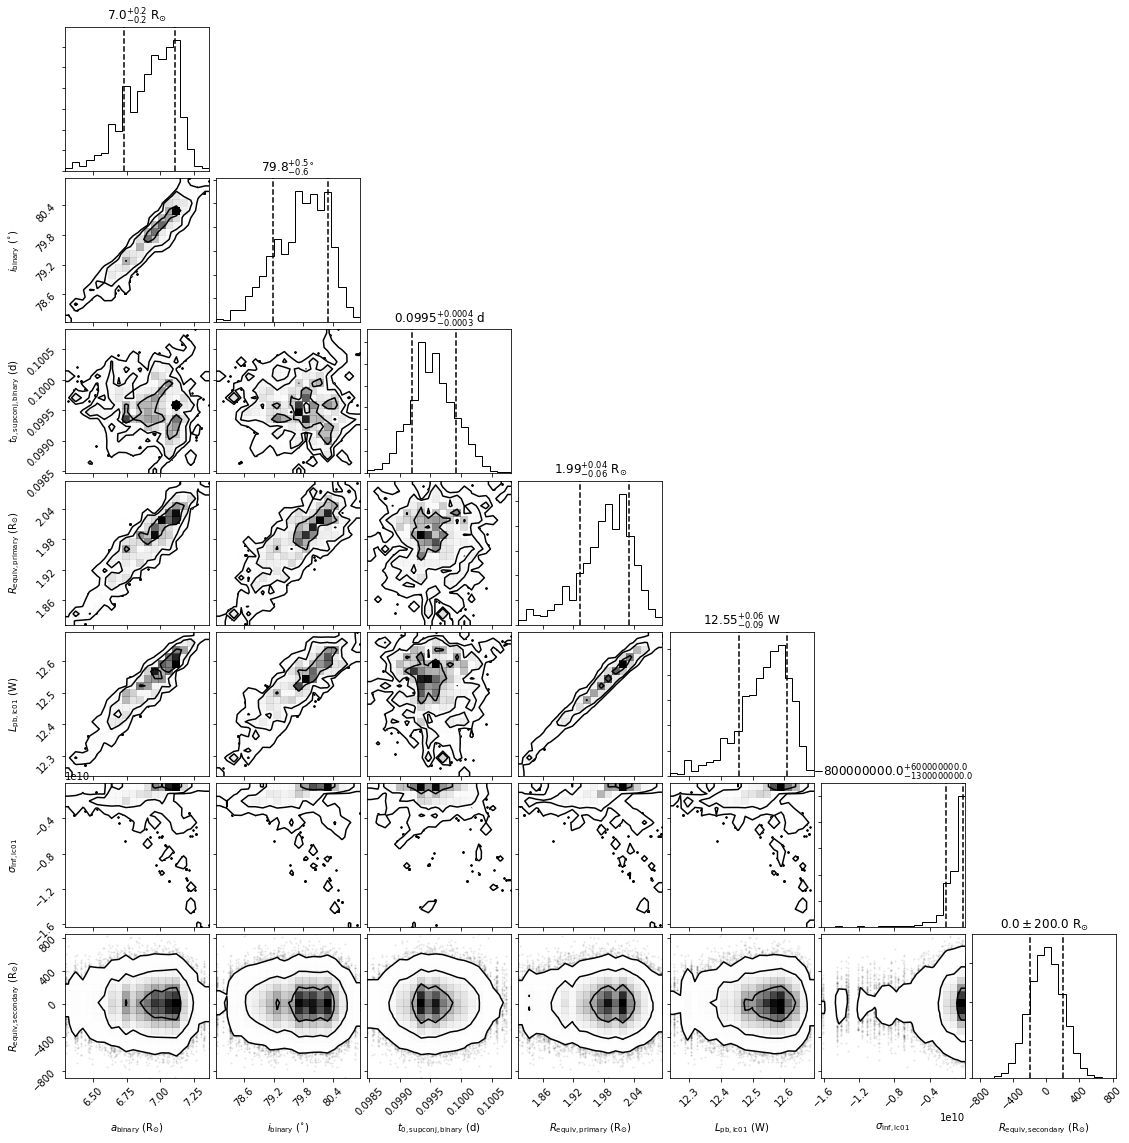

In [14]:
_ = b.plot_distribution_collection('init_from@emcee_solver', show=True)

Once we're happy with all of our options, we would call [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver) as in the [emcee tutorial](./emcee.ipynb).

## See Also

See the following for even more advanced use cases of emcee.

* [Advanced: continue emcee from a previous run](./emcee_continue_from.ipynb)
* [Advanced: convert posterior distributions from EMCEE](./emcee_distributions_convert.ipynb)